In [1]:
import polars as pl
import altair as alt
import pandas as pd
import numpy as np
import sklearn

alt.data_transformers.enable('vegafusion')

DataTransformerRegistry.enable('vegafusion')

# Data Analysis

In [2]:
df = pl.read_csv('data/train.csv')

In [3]:
df

id,path,label
str,str,str
"""9bb25bc386d6495b9f9ae35f08e708…","""train/EASTERN PINE ELFIN/9bb25…","""EASTERN PINE ELFIN"""
"""ecddd57d14c64015b906acde50307a…","""train/LARGE MARBLE/ecddd57d14c…","""LARGE MARBLE"""
"""50bdd6a608f04f04bb1d8872144238…","""train/PAPER KITE/50bdd6a608f04…","""PAPER KITE"""
"""4e84f59a9a7e42eda7ba4cd6c65efe…","""train/RED POSTMAN/4e84f59a9a7e…","""RED POSTMAN"""
"""1fa1f3e8c2c14fe08175bcac63f16b…","""train/GREEN HAIRSTREAK/1fa1f3e…","""GREEN HAIRSTREAK"""
…,…,…
"""7455fd21d23f4a56854241a1b9fe38…","""train/JULIA/7455fd21d23f4a5685…","""JULIA"""
"""28fe8ba799cf4c7a913e8d71a634e8…","""train/CLOUDED SULPHUR/28fe8ba7…","""CLOUDED SULPHUR"""
"""67e397373fcd4b498beeb4154d3973…","""train/BLUE SPOTTED CROW/67e397…","""BLUE SPOTTED CROW"""


## Species Distribution

In [4]:
base = alt.Chart(df).mark_bar().encode(
    x=alt.X('label:O', title='Butterfly Species', axis=alt.Axis(labelAngle=45)),
    y=alt.Y('count()', title='Frequency'),
    color=alt.Color('label:N', title=''),
    tooltip=[
        alt.Tooltip('label:O', title='Butterfly Species'),
        alt.Tooltip('count()', title='Frequency')
    ],
)

final_chart = (base).properties(
    width=1200,
    height=400,
    title='Distribution of 100 Butterfly Species'
)

final_chart

alt.Chart(...)

Data is slightly imbalanced

## Butterflies Examples

Found 100 classes, showing up to 20 examples from each different class


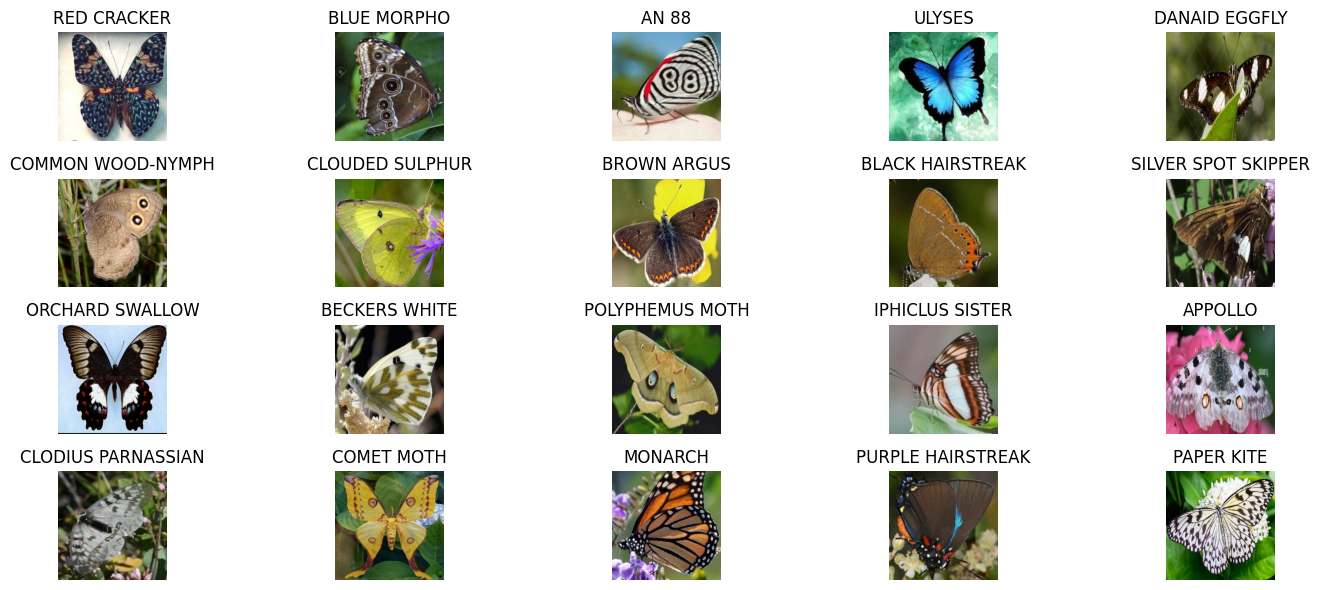

In [5]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

base_dir = 'data/train'
classes = [d for d in sorted(os.listdir(base_dir)) if os.path.isdir(os.path.join(base_dir, d))]
n = 20
print(f'Found {len(classes)} classes, showing up to {n} examples from each different class')
random.seed(42)
selected = classes if len(classes) <= n else random.sample(classes, n)

fig, axes = plt.subplots(n // 5, 5, figsize=(15,6))
axes = axes.flatten()
for ax, cls in zip(axes, selected):
    cls_dir = os.path.join(base_dir, cls)
    imgs = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    if not imgs:
        ax.set_title(cls)
        ax.axis('off')
        continue
    img_path = os.path.join(cls_dir, random.choice(imgs))
    try:
        img = Image.open(img_path).convert('RGB')
        ax.imshow(img)
    except Exception as e:
        ax.text(0.5,0.5,'Error loading image',ha='center')
    ax.set_title(cls)
    ax.axis('off')

for ax in axes[len(selected):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

## Data Statistics

In [ ]:
# Compute image resolution statistics across the `train/` dataset
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

base_dir = 'data/train'
class_dirs = [d for d in sorted(os.listdir(base_dir)) if os.path.isdir(os.path.join(base_dir, d))]
records = []
for cls in class_dirs:
    cls_dir = os.path.join(base_dir, cls)
    for fname in os.listdir(cls_dir):
        if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        path = os.path.join(cls_dir, fname)
        try:
            with Image.open(path) as im:
                w, h = im.size
        except Exception:
            # skip files we can't open
            continue
        records.append({'class': cls, 'file': path, 'width': int(w), 'height': int(h)})

df_sizes = pd.DataFrame(records)
if df_sizes.empty:
    print('No images found under', base_dir)
else:
    print('Total images:', len(df_sizes))
    print('Classes found:', df_sizes['class'].nunique())
    df_sizes['area'] = df_sizes['width'] * df_sizes['height']
    display(df_sizes[['width','height']].describe())

Total images: 10911
Classes found: 100


,width,height
count,10911.0,10911.0
mean,224.0,224.0
std,0.0,0.0
min,224.0,224.0
25%,224.0,224.0
50%,224.0,224.0
75%,224.0,224.0
max,224.0,224.0


# Data Preparation

How Dataset and DataLoader works https://docs.pytorch.org/vision/stable/datasets.html

## Image Augmentation

All transformations: https://docs.pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py

In [ ]:
import os
import torch
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split


transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

dataset = torchvision.datasets.ImageFolder("data/train/", transform=transform)

## Data Loaders

In [8]:
train_idx, val_idx = train_test_split(
    list(range(len(dataset))),
    test_size=0.2,
    stratify=dataset.targets,
    random_state=42
)

train_ds = Subset(dataset, train_idx)
val_ds   = Subset(dataset, val_idx)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=torch.cuda.is_available())
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=torch.cuda.is_available())

In [9]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# MLflow

In [6]:
import mlflow
import os

mlflow.autolog(disable=True)

In [7]:
mlflow.login()

2025/11/20 11:55:40 INFO mlflow.utils.credentials: Successfully connected to MLflow hosted tracking server! Host: https://dbc-5c01ef19-8d4a.cloud.databricks.com.


# Setup for faster training

Check GPU

In [38]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 Laptop GPU (UUID: GPU-292a70b4-16ec-9db7-4565-3e3905bb61de)


## Mixed Precision for A100 GPU

the image below can be also applied to some other GPUs, you can easily check it in the internet

For example I can it apply for mine

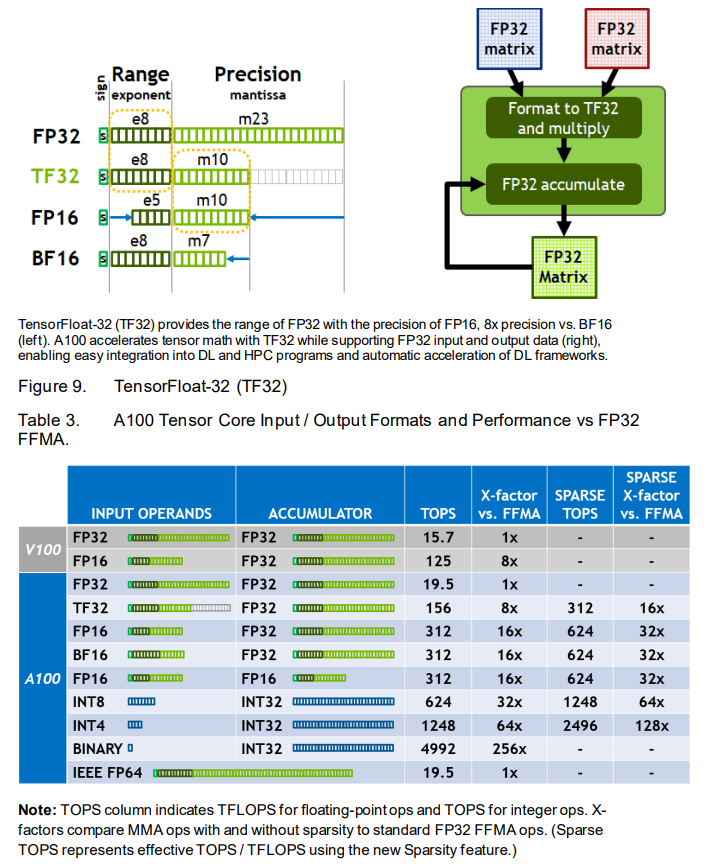

## TF32 Support

I have a NVIDIA GeForce RTX 3060 laptop GPU which supports TF32 for MatMul Operations

Check the TF32 support by running code below

In [10]:
torch.cuda.is_tf32_supported()

True

Set the TF32 MatMul operations

In [11]:
torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

## BF16 Support

Check the BF16 support by running code below

In [12]:
torch.cuda.is_bf16_supported()

True

The BF16 would be implemented in the train.py model in Trainer class with this line:

In [42]:
with torch.autocast(device_type='cpu', dtype=torch.bfloat16):
    pass

## Optimizations for Convolutions

### Below are flags for torch.compile

https://pytorch.org/blog/accelerating-generative-ai-3/#:~:text=Specifying%C2%A0fullgraph%C2%A0to%20be%C2%A0True%C2%A0ensures%20that%20there%20are%20no%20graph%20breaks%20in%20the%20underlying%20model%2C%20ensuring%20the%20fullest%20potential%20of%C2%A0torch.compile.%20In%20our%20case%2C%20the%20following%20compiler%20flags%20were%20also%20important%20to%20be%20explicitly%20set%3A

In [43]:
torch._inductor.config.conv_1x1_as_mm = True
torch._inductor.config.coordinate_descent_tuning = True
torch._inductor.config.epilogue_fusion = True
torch._inductor.config.coordinate_descent_check_all_directions = True

### About Channels Last

https://docs.pytorch.org/tutorials/intermediate/memory_format_tutorial.html#:~:text=Channels%20last%20memory%20format%20optimizations,uses%20AMP%20supplied%20by%20NVIDIA

In [ ]:
from models import AlexNet

model = AlexNet(100).to(device)

model.to(memory_format=torch.channels_last)

## Torch Compile

torch compile is almost as GCC for a C++ code

### Kernel Fusion

The most improvement in terms of training speed happens because of Kernel Fusion

Kernel fusion involves combining the operations of multiple individual computational kernels (or operators) into a single, larger kernel.

The following compilation graphs will make the picture clearer.

High level overview of GPU and CPU relation

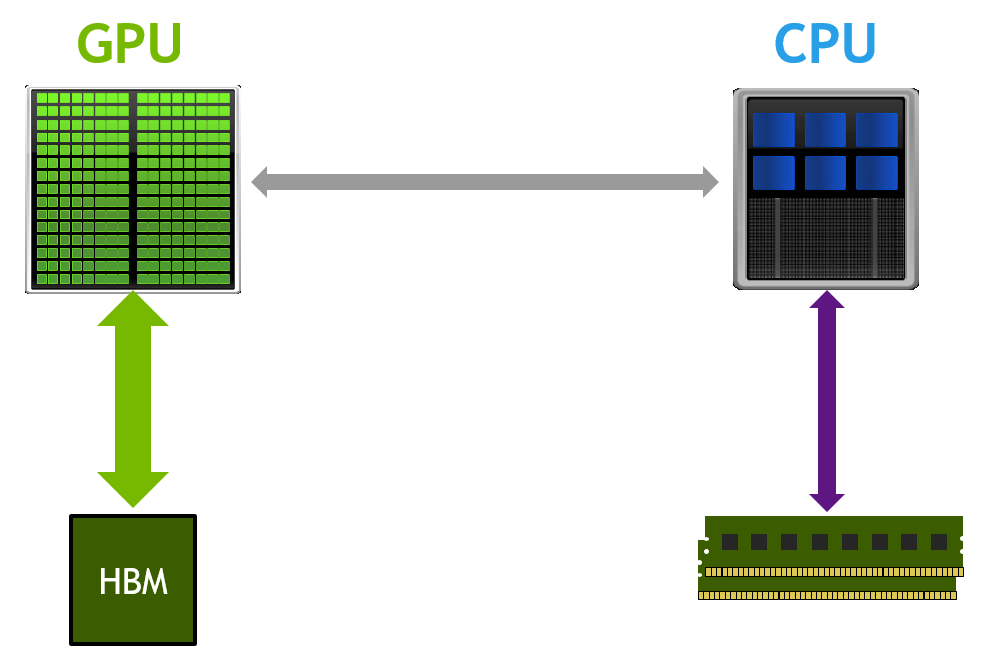

Memory Hierarchy

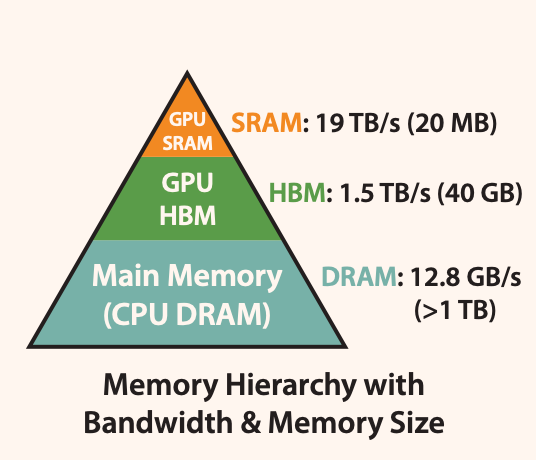

### Model Graph Before Compilation

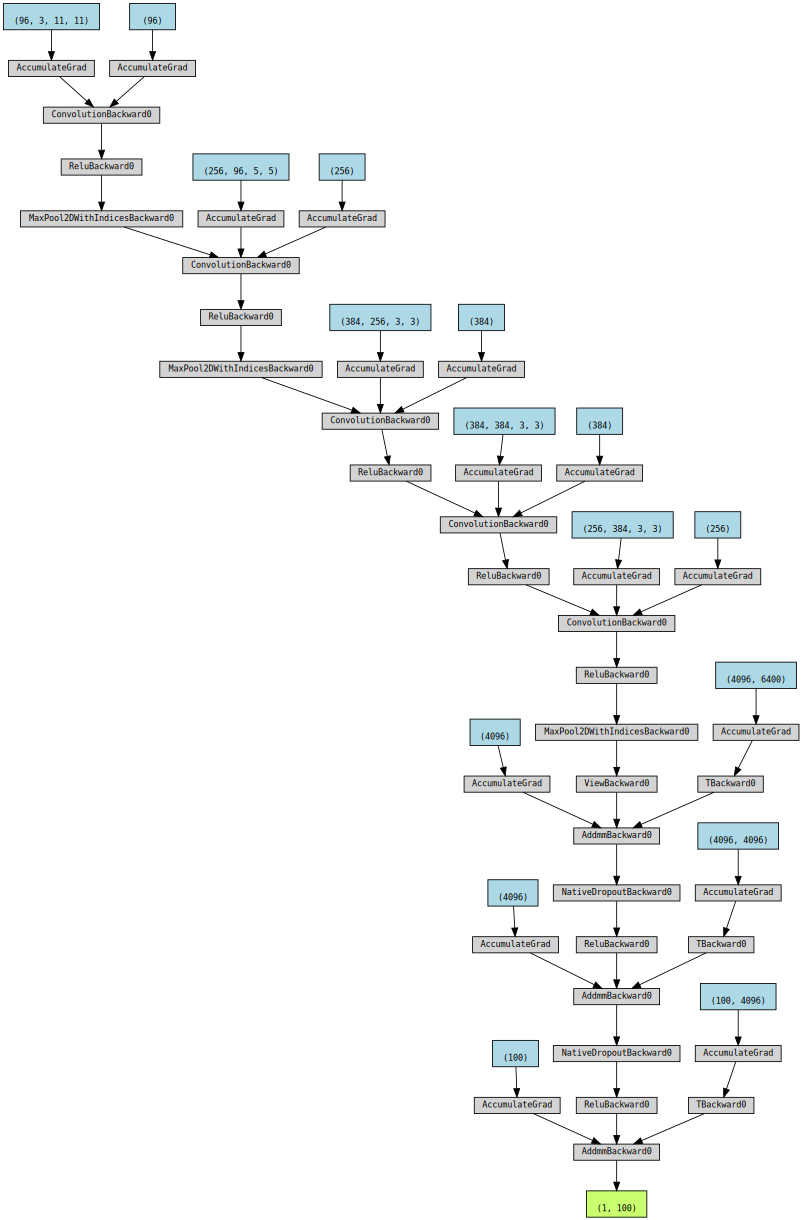

In [13]:
from models import AlexNet
from torchviz import make_dot

model = AlexNet(100).to(device)

x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False, device=device)
out = model(x)
make_dot(out)

### Model training speed before Compilation

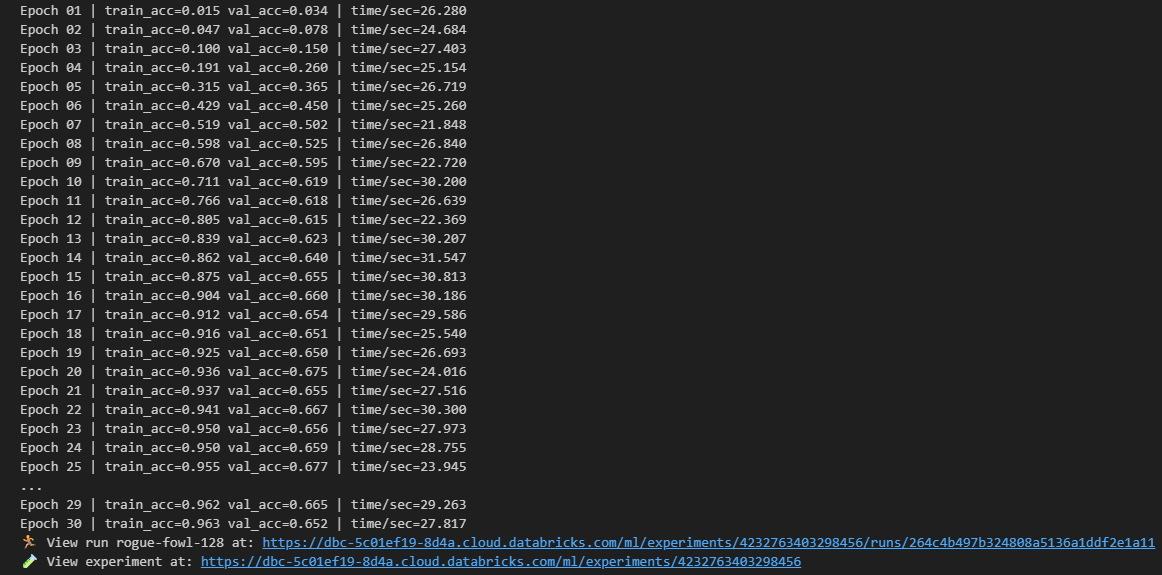

### Model Graph After Compilation

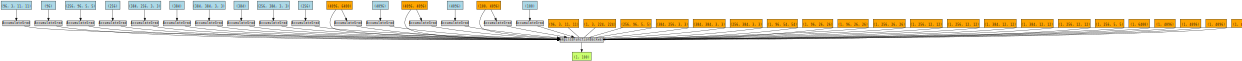

In [24]:
from models import AlexNet
from torchviz import make_dot

model = AlexNet(100).to(device)

x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False, device=device)

with torch.no_grad():
    out = model(x)

model = torch.compile(model, mode="max-autotune", fullgraph=True)

logits = model(x)
dot = make_dot(logits)

dot

### Model training speed after Compilation

Training is faster by ~ 2.5x

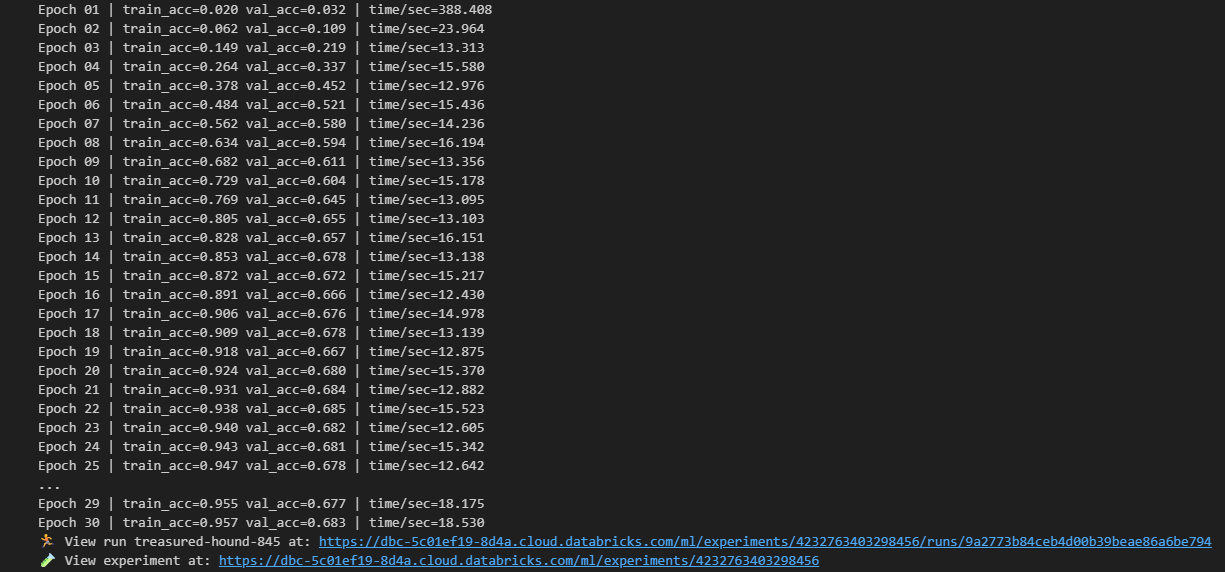

# Training Convolutional Models

## LeNet Architecture

The architecture was taken from the lecture

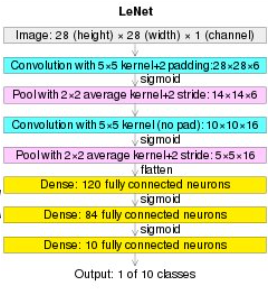
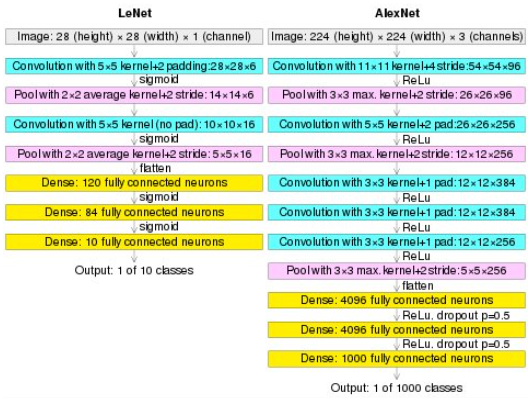

In [ ]:
from models import LeNet

model = LeNet(100).to(device)

In [ ]:
from trainer import Trainer

trainer = Trainer(model=model)

In [ ]:
trainer.fit(
    train_loader=train_loader, 
    val_loader=val_loader, 
    epochs=30
)

Epoch 01 | train_acc=0.010 val_acc=0.014
Epoch 02 | train_acc=0.013 val_acc=0.013
Epoch 02 | train_acc=0.013 val_acc=0.013
Epoch 03 | train_acc=0.012 val_acc=0.014
Epoch 03 | train_acc=0.012 val_acc=0.014
Epoch 04 | train_acc=0.014 val_acc=0.014
Epoch 04 | train_acc=0.014 val_acc=0.014
Epoch 05 | train_acc=0.012 val_acc=0.013
Epoch 05 | train_acc=0.012 val_acc=0.013
Epoch 06 | train_acc=0.012 val_acc=0.014
Epoch 06 | train_acc=0.012 val_acc=0.014
Epoch 07 | train_acc=0.014 val_acc=0.014
Epoch 07 | train_acc=0.014 val_acc=0.014
Epoch 08 | train_acc=0.014 val_acc=0.014
Epoch 08 | train_acc=0.014 val_acc=0.014
Epoch 09 | train_acc=0.014 val_acc=0.014
Epoch 09 | train_acc=0.014 val_acc=0.014
Epoch 10 | train_acc=0.014 val_acc=0.014
Epoch 10 | train_acc=0.014 val_acc=0.014
Epoch 11 | train_acc=0.013 val_acc=0.014
Epoch 11 | train_acc=0.013 val_acc=0.014
Epoch 12 | train_acc=0.014 val_acc=0.014
Epoch 12 | train_acc=0.014 val_acc=0.014
Epoch 13 | train_acc=0.014 val_acc=0.014
Epoch 13 | train

## AlexNet Architecture

The architecture was taken from the lecture

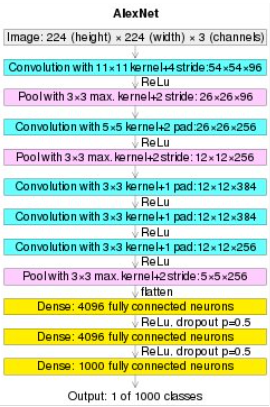
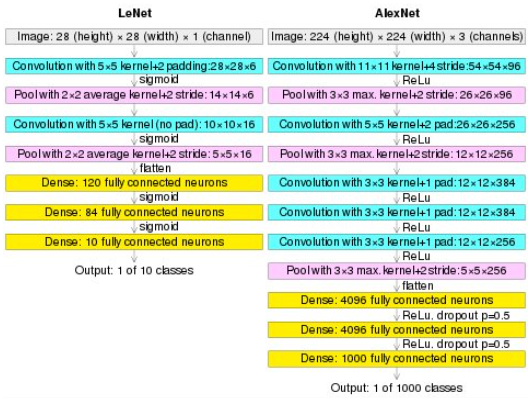

In [12]:
from models import AlexNet

model = AlexNet(100).to(device)

In [ ]:
from trainer import Trainer

trainer = Trainer(model=model)

In [14]:
trainer.fit(
    train_loader=train_loader, 
    val_loader=val_loader, 
    epochs=30
)

Epoch 01 | train_acc=0.015 val_acc=0.034 | time/sec=26.280
Epoch 02 | train_acc=0.047 val_acc=0.078 | time/sec=24.684
Epoch 03 | train_acc=0.100 val_acc=0.150 | time/sec=27.403
Epoch 04 | train_acc=0.191 val_acc=0.260 | time/sec=25.154
Epoch 05 | train_acc=0.315 val_acc=0.365 | time/sec=26.719
Epoch 06 | train_acc=0.429 val_acc=0.450 | time/sec=25.260
Epoch 07 | train_acc=0.519 val_acc=0.502 | time/sec=21.848
Epoch 08 | train_acc=0.598 val_acc=0.525 | time/sec=26.840
Epoch 09 | train_acc=0.670 val_acc=0.595 | time/sec=22.720
Epoch 10 | train_acc=0.711 val_acc=0.619 | time/sec=30.200
Epoch 11 | train_acc=0.766 val_acc=0.618 | time/sec=26.639
Epoch 12 | train_acc=0.805 val_acc=0.615 | time/sec=22.369
Epoch 13 | train_acc=0.839 val_acc=0.623 | time/sec=30.207
Epoch 14 | train_acc=0.862 val_acc=0.640 | time/sec=31.547
Epoch 15 | train_acc=0.875 val_acc=0.655 | time/sec=30.813
Epoch 16 | train_acc=0.904 val_acc=0.660 | time/sec=30.186
Epoch 17 | train_acc=0.912 val_acc=0.654 | time/sec=29.5

## VGGNet Architecture

The architecture image was taken from the Dive Into Deep Learning website ( also can be found in lecture )

https://d2l.ai/chapter_convolutional-modern/vgg.html


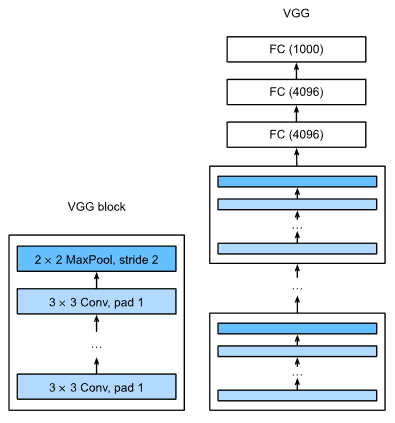
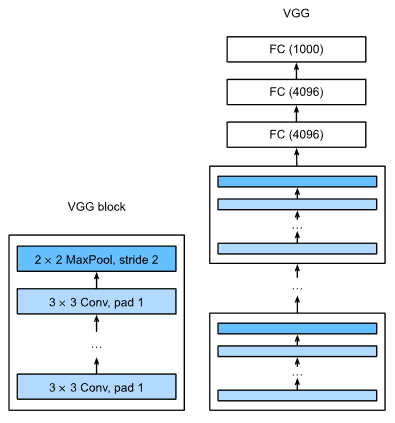
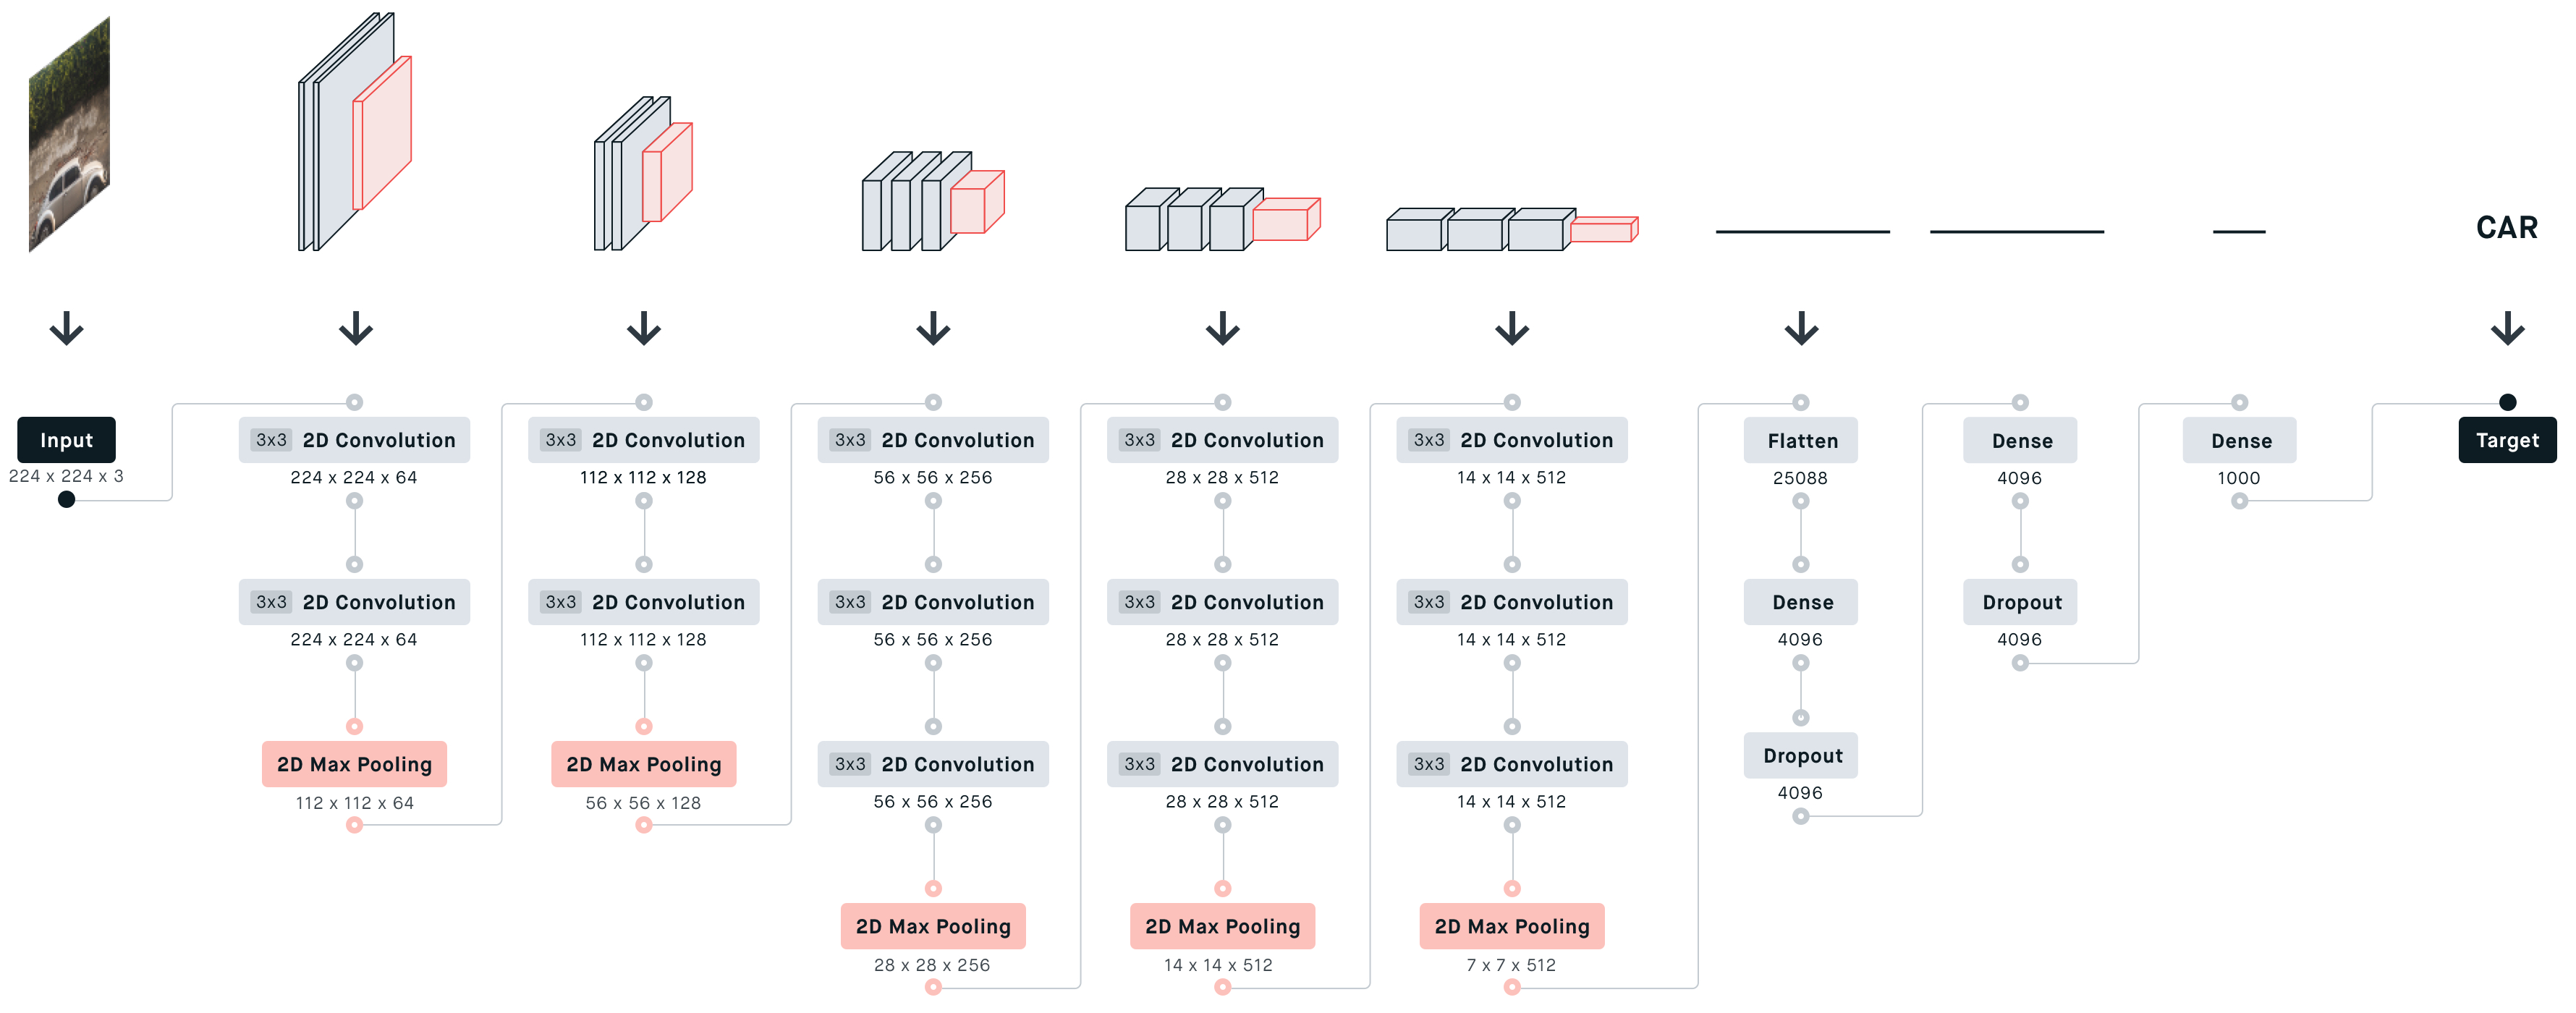

In [ ]:
from models import VGGNet

config = (
    (16, 1),
    (32, 1),
    (64, 2),
    (128, 2),
    (128, 2)
)

model = VGGNet(config, 100).to(device)

In [ ]:
from trainer import Trainer
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

trainer = Trainer(model=model, optimizer=optimizer)

In [ ]:
trainer.fit(
    train_loader=train_loader, 
    val_loader=val_loader, 
    epochs=5
)

Epoch 01 | train_acc=0.012 val_acc=0.014
Epoch 02 | train_acc=0.014 val_acc=0.014
Epoch 03 | train_acc=0.014 val_acc=0.014


## NiN Architecture

The architecture image was taken from the Dive Into Deep Learning website ( also can be found in lecture )

https://d2l.ai/chapter_convolutional-modern/nin.html

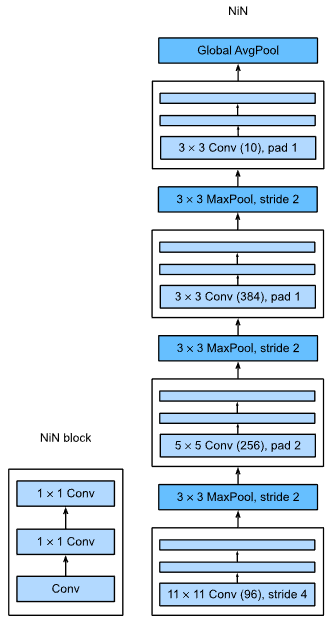

In [12]:
from models import NiN

config = (
    (96, 11, 4, 0),
    (256, 5, 1, 2),
    (384, 3, 1, 1)
)

model = NiN(config, 100).to(device)

In [ ]:
from trainer import Trainer
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0)

trainer = Trainer(model=model, optimizer=optimizer)

In [14]:
trainer.fit(
    train_loader=train_loader, 
    val_loader=val_loader, 
    epochs=60
)

Epoch 01 | train_acc=0.015 val_acc=0.018 | time/sec=60.112
Epoch 02 | train_acc=0.031 val_acc=0.038 | time/sec=35.245
Epoch 03 | train_acc=0.038 val_acc=0.043 | time/sec=35.805
Epoch 04 | train_acc=0.048 val_acc=0.053 | time/sec=34.378
Epoch 05 | train_acc=0.059 val_acc=0.063 | time/sec=31.101
Epoch 06 | train_acc=0.071 val_acc=0.096 | time/sec=32.497
Epoch 07 | train_acc=0.106 val_acc=0.129 | time/sec=32.500
Epoch 08 | train_acc=0.140 val_acc=0.150 | time/sec=33.241
Epoch 09 | train_acc=0.158 val_acc=0.185 | time/sec=37.060
Epoch 10 | train_acc=0.184 val_acc=0.182 | time/sec=32.861
Epoch 11 | train_acc=0.198 val_acc=0.194 | time/sec=35.992
Epoch 12 | train_acc=0.217 val_acc=0.215 | time/sec=33.283
Epoch 13 | train_acc=0.226 val_acc=0.233 | time/sec=33.612
Epoch 14 | train_acc=0.244 val_acc=0.228 | time/sec=32.327
Epoch 15 | train_acc=0.250 val_acc=0.247 | time/sec=31.262
Epoch 16 | train_acc=0.265 val_acc=0.253 | time/sec=34.755
Epoch 17 | train_acc=0.278 val_acc=0.258 | time/sec=35.1

## GoogLeNet Architecture

The architecture image was taken from the Dive Into Deep Learning website ( also can be found in lecture )

https://d2l.ai/chapter_convolutional-modern/googlenet.html

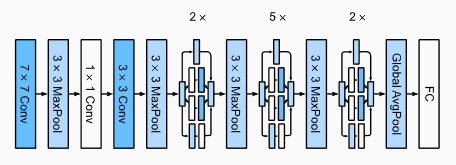

In [12]:
from models import GoogLeNet

model = GoogLeNet(100).to(device)

In [ ]:
from trainer import Trainer
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

trainer = Trainer(model=model, optimizer=optimizer)

In [ ]:
trainer.fit(
    train_loader=train_loader, 
    val_loader=val_loader, 
    epochs=30
)

# Transfer Learning

## Training Vison Transformer Model

In [22]:
import timm
from timm.data import resolve_model_data_config, create_transform
from torch import nn
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

In [14]:
MODEL_NAME = "vit_base_patch16_224.augreg_in21k_ft_in1k"

In [15]:
_tmp_model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=100)
data_config = resolve_model_data_config(_tmp_model)

In [16]:
train_transform = create_transform(**data_config, is_training=True)
val_transform   = create_transform(**data_config, is_training=False)

In [17]:
from torchvision import datasets
dataset_train = datasets.ImageFolder("data/train/", transform=train_transform)
dataset_val   = datasets.ImageFolder("data/train/", transform=val_transform)

In [23]:
train_idx, val_idx = train_test_split(
    list(range(len(dataset_train))),
    test_size=0.2,
    stratify=dataset_train.targets,
    random_state=42
)

In [24]:
train_ds = Subset(dataset_train, train_idx)
val_ds   = Subset(dataset_val,   val_idx)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=torch.cuda.is_available())
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=torch.cuda.is_available())

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

In [31]:
from models import ViT
base_model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=100)
model = ViT(base_model).to(device)

In [32]:
from trainer import Trainer
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=5e-4)

trainer = Trainer(model=model, optimizer=optimizer)

trainer.fit(
    train_loader=train_loader, 
    val_loader=val_loader, 
    epochs=15
)

🏃 View run intrigued-cub-300 at: https://dbc-5c01ef19-8d4a.cloud.databricks.com/ml/experiments/4479259686441994/runs/cce95b99157f4165bfc4d7b7e513582f
🧪 View experiment at: https://dbc-5c01ef19-8d4a.cloud.databricks.com/ml/experiments/4479259686441994


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2

from dataset import TestImageDataset, load_class_names
from trainer import Trainer

# Use the same normalization pipeline as validation
test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # v2.Resize((224, 224)),  # uncomment if test images are not 224x224
])

test_ds = TestImageDataset("data/test", transform=test_transform)
test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    num_workers=1,
    pin_memory=torch.cuda.is_available(),
)

class_names = load_class_names("data/classes.txt")

# Assuming you already have a trained `trainer` (with model on device)
# If not, recreate the model, load weights, and wrap with Trainer first.
submission_path = trainer.create_submission(test_loader, class_names, "submission.csv")
print("Wrote:", submission_path)

In [30]:
from dataset import TestImageDataset, load_class_names
from torch.utils.data import DataLoader

test_ds = TestImageDataset("data/test", transform=val_transform)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=1, pin_memory=torch.cuda.is_available())

class_names = load_class_names("data/classes.txt")
trainer.create_submission(test_loader, class_names, "submission.csv")

'submission.csv'